# ECE 6254 - Statistical Machine Learning
## Project - Loonie
### Mathematical Analysis of Undersampling 

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics
from matplotlib.transforms import Bbox

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, roc_curve
from tqdm import tqdm


#### Function Definition

In [2]:
def plot_histogram(x_mi, x_ma, undersampled=False):
    if undersampled:
         plt.hist(x_ma, bins=25, alpha=0.6, color='r', label='Majority Class Undersampled')
    else:
        plt.hist(x_ma, bins=25, alpha=0.6, color='r', label='Majority Class')
    plt.hist(x_mi, bins=25, alpha=0.6, color='b', label='Minority Class')

    plt.grid(True,which='major',linewidth=0.5)
    plt.grid(True,which='minor',linewidth=0.1)
    plt.xlabel("$x$")
    plt.ylabel("Count")
    plt.legend(loc='upper left',fontsize='small')

In [3]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    #items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    #items += [ax, ax.title]
    items += [ax.get_xaxis().get_label(), ax.get_yaxis().get_label()]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(0.98 + pad, 0.93 + pad)

In [4]:
def posterior_bias(x_mi, x_ma, pi_mi, Beta_opt, graph_name, range_min=-15, range_max=15):
    fig = plt.figure(figsize=(7,10))
    ax1 = fig.add_subplot(2,1,1) #First subplot -> Histogram of growing \Beta
    ax2 = fig.add_subplot(2,1,2) #Second subplot -> Bias in probability
    n_mi, bin_mi, bars = ax1.hist(x_mi, bins=range(range_min, range_max, 1), alpha=0.4, color='b', label='Minority Class')
    
    for ii in range(0, len(Beta_opt)):
        x_ma_undersampled = x_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta_opt[ii]*(1-pi_mi)*N))]
        n_ma, bin_ma, bars = ax1.hist(x_ma_undersampled, bins=range(range_min, range_max, 1), alpha=0.3, color='r',
                                      label=['Majority Class Undersampled with B='+str(Beta_opt[ii])])
        ind=np.where((n_mi+n_ma)>0)
        p_us_mi= n_mi[ind]/(n_mi[ind]+n_ma[ind])
        ax2.plot(bin_ma[ind]+0.5, p_us_mi,  'o-', label=r'$\beta = $'+str(Beta_opt[ii])) #alpha=0.3,

    plt.xlabel("$x$")
    plt.ylabel("$p$")
    plt.grid(True,which='major',linewidth=0.5)
    plt.grid(True,which='minor',linewidth=0.1)
    plt.legend(loc='lower left',fontsize='small')
    plt.xlim([range_min+5,range_max-5])
    ax1.set_ylabel('Count')
    ax1.set_xlabel('$x$')
    ax1.grid()
    
    #Save the figure of the posterior bias only
    # Save just the portion _inside_ the second axis's boundaries
    extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(graph_name, bbox_inches=extent)

# Let's start simple in 1 Dimension

In [5]:
pi_mi = 0.3    # Proportion of minority class
N = 1e7       # Total number of samples
mu_mi = 0
sigma_mi = 3
mu_ma = 3
sigma_ma = 3

In [6]:
# Samples of minority class
x_mi = np.random.normal(loc=mu_mi, scale=sigma_mi, size=(int(pi_mi*N), 1))
# Samples of majority class
x_ma = np.random.normal(loc=mu_ma, scale=sigma_ma, size=(int((1-pi_mi)*N), 1))

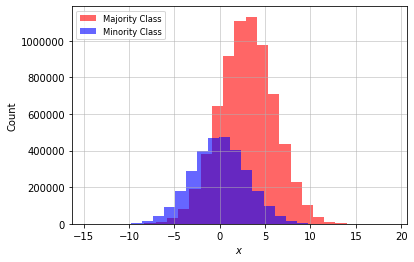

In [7]:
plot_histogram(x_mi, x_ma)

In [8]:
Beta = 0.25 # Probability of selecting a sample from the majority class
x_ma_undersampled = x_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N))]

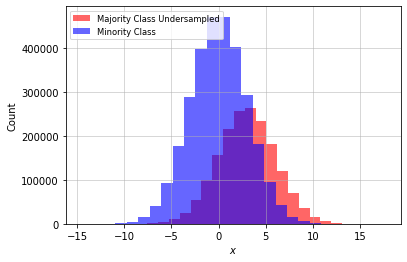

In [9]:
# Plot the udersampled histogram.
plot_histogram(x_mi, x_ma_undersampled, True)

## 1. Complexity of Hypothesis Set
Undersampling removes samples from the majority dataset. The number of samples available limits the complexity of the hypothesis dataset over which the ML algorithm can generalize.
<br><br>
This consequence should be addressed in the report but no specific coding is needed.

## 2. Sampling Selection Bias
https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf <br>


### Posterior Probability

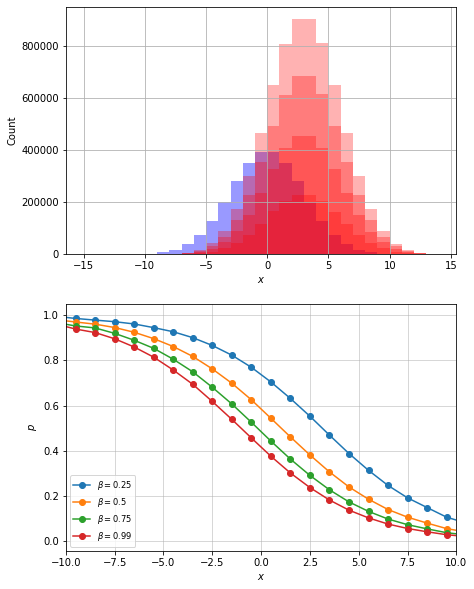

In [10]:
Beta_opt = [0.25, 0.5, 0.75, 0.99] # Probability of selecting a sample from the majority class
graph_name = 'posterior_bias.png'
posterior_bias(x_mi, x_ma, pi_mi, Beta_opt, graph_name)


As $\beta$ decreases the posterior probability, $\mathbb{P}(\mathrm{minority}|x)$, decreases. In other words, removing samples with undersampling moves the classification boundary so that more samples are classified as the minority. The stronger
the undersampling, the larger the shift.

### How does separability affect the bias?
We expect that the more separable, the lower the bias/shift.

In [11]:
mu_ma = 13 # Increased the distance between classes by 10
x_ma_separated = np.random.normal(loc=mu_ma, scale=sigma_ma, size=(int((1-pi_mi)*N), 1))

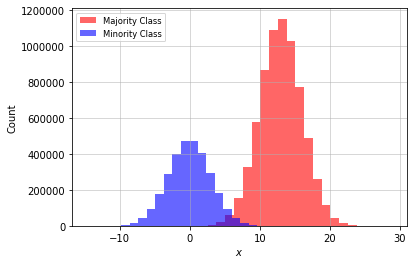

In [12]:
# Plot separated histogram.
plot_histogram(x_mi, x_ma_separated)

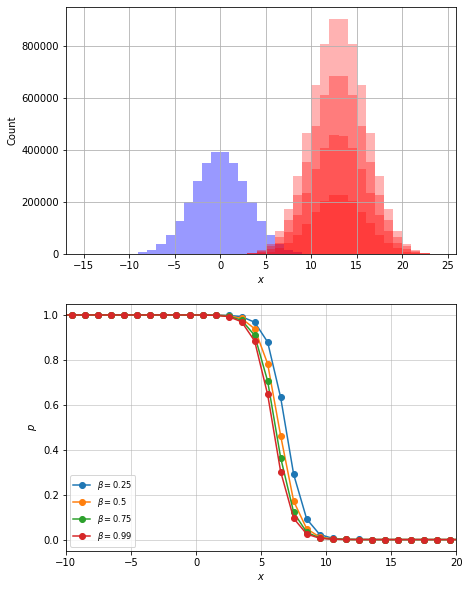

In [13]:
Beta_opt = [0.25, 0.5, 0.75, 0.99] # Probability of selecting a sample from the majority class
graph_name = 'posterior_bias_separated.png'
posterior_bias(x_mi, x_ma_separated, pi_mi, Beta_opt, graph_name, range_max=25)

## 3. Sample Variance

In [14]:
Beta_opt_percentage = [5,10,15,20,25,40,60,80,95]
#variance = [0] * len(Beta_opt_percentage)
pvariance = [0] * len(Beta_opt_percentage)
#stdev = [0] * len(Beta_opt_percentage)
iterations = 1000
for iter in range(0, iterations):
    x = np.random.normal(loc=0, scale=10, size=(100, 1))
    for jj in range(0, len(Beta_opt_percentage)):
        x_undersampled = x[random.sample(range(1, 100), Beta_opt_percentage[jj]*1)]
        #variance[jj] = variance[jj] + statistics.variance(x_undersampled[:, 0])
        pvariance[jj] = pvariance[jj] + statistics.pvariance(x_undersampled[:, 0])
        #stdev[jj] = stdev[jj] + statistics.stdev(x_undersampled[:, 0], xbar=0)

In [15]:
#variance = [x / iterations for x in variance]
pvariance = [x / iterations for x in pvariance]
#stdev = [x / iterations for x in stdev]
#stdev = [x*x for x in stdev]

Text(0, 0.5, '$\\sigma^2$')

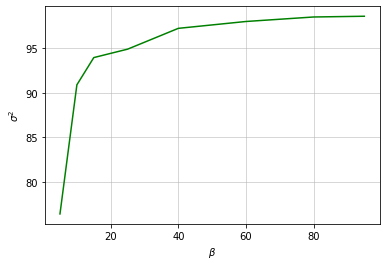

In [16]:
#plt.plot(Beta_opt_percentage, variance, 'r')
plt.plot(Beta_opt_percentage, pvariance, 'g')
#plt.plot(Beta_opt_percentage, stdev, 'b')
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)
plt.xlabel(r"$\beta$")
plt.ylabel("$\sigma^2$")

As the undersampling is less agressive, that is, as the number of samples in the majority classes employed increases, the estimated variance approaches the true variance: $\sigma^2 = 100$

### Standard Error of the Mean (SEM)

The Standard Error of the Mean (SEM), which gives the standard deviation of the sample mean of  $N$  values from a normal distribution:
$$
\mathrm{SEM}=\frac{\sigma}{\sqrt{N}}\approx\frac{\sigma_{s}}{\sqrt{N}},
$$
where $\sigma_s$ is the sample stardard deviation.

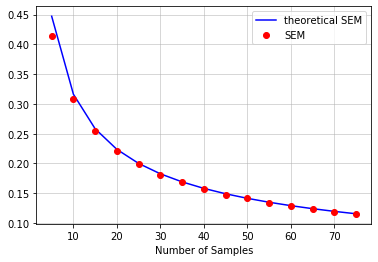

In [17]:
iterations = 1000
nts = np.arange(5, 80,5)
n_nts = len(nts)

SEMs = 1 / np.sqrt(nts)  # theory, for normal distribution

sems_exp = np.zeros(nts.shape)
sems_sample = np.zeros(nts.shape)

for i, nt in enumerate(nts):
    y = np.random.randn(iterations, nt)
    y_means = y.mean(axis=1)
    y_stds = y.std(axis=1, ddof=1)
    sems_exp[i] = y_means.std()
    sems_sample[i] = y_stds.mean() / np.sqrt(nt)
    
fig, ax = plt.subplots()
#ax.plot(nts, sems_exp, 'gx', label='std dev of mean')
ax.plot(nts, SEMs, 'b-', label='theoretical SEM')
ax.plot(nts, sems_sample, 'ro', label='SEM')
ax.locator_params(axis='x', integer=True)
ax.legend(loc='upper right')
ax.set_xlabel('Number of Samples');
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)

As the sample size increases, sample means cluster more closely around the population mean.

Note that for few number of samples we uderestimate the SEM. This is because the SEM is calculated based on $\sigma_s$, which as we saw on some homework, is biased (Not ussing Bessels correction $\rightarrow N-1$).

# Let's translate the findings to 2 Dimensions

#### Definition of functions

In [18]:
def multivariate_gaussian(pos, mu, Sigma): #Copied from Cristian's code
    """Return the multivariate Gaussian distribution on array pos."""
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

In [19]:
def Plot2DGaussians_Distribution(x_grid, y_grid, Z1, Z2):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1,projection='3d')
    ax2 = fig.add_subplot(2,2,2,projection='3d')
    ax3 = fig.add_subplot(2,2,3,projection='3d')

    # Plot the surface.
    surf2 = ax1.plot_surface(x_grid, y_grid, Z1, cmap=cm.Reds,
                       linewidth=0, antialiased=False, alpha=0.9)

    cset = ax3.contourf(x_grid, y_grid, Z1, zdir='z', offset=0, cmap=cm.Reds)
    cset = ax2.contourf(x_grid, y_grid, Z1, zdir='x', offset=0, cmap=cm.Reds)
    #cset = ax.contourf(x_grid, y_grid, Z1, zdir='y', offset=4, cmap=cm.Reds)

    surf = ax1.plot_surface(x_grid, y_grid, Z2, cmap=cm.Blues,
                       linewidth=0, antialiased=False, alpha=0.3)

    cset = ax3.contourf(x_grid, y_grid, Z2, zdir='z', offset=0, cmap=cm.Blues, alpha=0.3)
    cset = ax2.contourf(x_grid, y_grid, Z2, zdir='x', offset=0, cmap=cm.Blues)#, alpha=0.3)
    #cset = ax.contourf(x_grid, y_grid, Z2, zdir='y', offset=4, cmap=cm.Blues)#, alpha=0.3)

    # Customize axis.
    ax1.set_zlim(0, 0.05)
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax3.set_xlim(-4, 4)
    ax3.set_ylim(-4, 4)
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-4, 4)
    ax2.set_xticks([])
    ax2.set_zlim(0, 0.05)
    ax3.set_zticks([])

    # Add a color bar which maps values to colors.
    #fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.65, 0.19, 0.02, 0.25])
    fig.colorbar(surf, cax=cbar_ax, shrink=0.7)
    cbar_ax = fig.add_axes([0.8, 0.19, 0.02, 0.25])
    fig.colorbar(surf2, cax=cbar_ax, aspect=5)

    ax1.view_init(10,150)
    ax2.view_init(0,-180)
    ax3.view_init(90,90)
    plt.show()

In [20]:
def Plot2D_Samples(x_grid, y_grid, z1, z2):
    x1 = z1[:,0]
    y1 = z1[:,1]
    x2 = z2[:,0]
    y2 = z2[:,1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    hist1, xedges, yedges = np.histogram2d(x1, y1, bins=20, range=[[-4, 4], [-4, 4]])
    hist2, xedges, yedges = np.histogram2d(x2, y2, bins=20, range=[[-4, 4], [-4, 4]])

    # Construct arrays for the anchor positions of the 16 bars.
    # Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
    # ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
    # with indexing='ij'.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)

    # Construct arrays with the dimensions for the bars.
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz1 = hist1.flatten()
    dz2 = hist2.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz1, color='b', zsort='average', alpha=1, label='Minority Class')
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz2, color='r', zsort='average', alpha=0.6, label='Majority Class')

    ax.view_init(10,150)
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="r")
    ax.legend([blue_proxy,red_proxy],['Minority Class','Majority Class'])
    plt.show()

In [21]:
def posterior_bias2D(data_ma, data_mi, Beta_opt, range_minx=-2, range_maxx=2, range_miny=-2, range_maxy=2):           
    color_opt = ['b', 'r', 'g', 'm', 'c', 'k']
    x_mi = data_mi[:,0]
    y_mi = data_mi[:,1]
    hist_mi, xedges, yedges = np.histogram2d(x_mi, y_mi, bins=100, 
                                             range=[[range_minx, range_maxx], [range_miny, range_maxy]])
    for ii in range(0, len(Beta_opt)):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        data_ma_undersampled = data_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta_opt[ii]*(1-pi_mi)*N)), :] 
        x_ma = data_ma_undersampled[:,0]
        y_ma = data_ma_undersampled[:,1]
        hist_ma, xedges, yedges = np.histogram2d(x_ma, y_ma, bins=100, 
                                                 range=[[range_minx, range_maxx], [range_miny, range_maxy]])
        ind=np.where((hist_mi+hist_ma)>0)
        p_us_mi= hist_mi[ind[0], ind[1]]/(hist_mi[ind[0], ind[1]]+hist_ma[ind[0], ind[1]])

        ax.scatter(xedges[ind[0]], yedges[ind[1]], p_us_mi, color=color_opt[ii])
        proxy = plt.Rectangle((0, 0), 1, 1, fc=color_opt[ii])
        plt.title(r'$\beta = $'+str(Beta_opt[ii]))
        #ax.view_init(10,0)
        ax.set_ylabel('$y$')
        ax.set_xlabel('$x$')
        ax.set_zlabel('$\mathbb{P}(\mathrm{minority}|x)$')
        ax.grid()
        plt.tight_layout()
    plt.show()

#### Intitialization of parameters

In [22]:
x_grid = np.linspace(-5,5,100)
y_grid = np.linspace(-5,5, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid

# Define Gaussians -> Same as Cristian's (Igual debería cambiar los valores en 1D)
pi_mi = 0.15    # Proportion of minority class
N = 100         # Total number of samples
mu_mi = [-1,-0.5]
sigma_mi = [[1,0],[0,1]]
mu_ma = [0,1]
sigma_ma = [[4,0],[0,2]]

#### Plot probability distributions

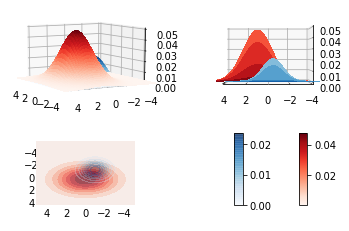

In [23]:
post_dist_ma = multivariate_gaussian(pos, np.array(mu_ma), np.array(sigma_ma))
post_dist_mi = multivariate_gaussian(pos, np.array(mu_mi), np.array(sigma_mi))

Plot2DGaussians_Distribution(x_grid,y_grid, post_dist_ma*(1-pi_mi), post_dist_mi*pi_mi)

#### Generate Dataset

In [24]:
N=1e6
x2D_ma = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N))
x2D_mi = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N))

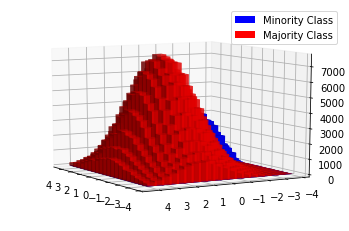

In [25]:
Plot2D_Samples(x_grid, y_grid, x2D_mi, x2D_ma)

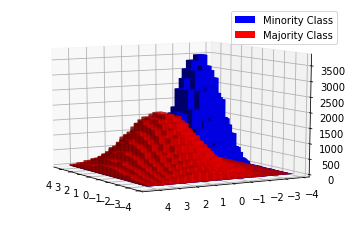

In [26]:
# What do we get if we undersample?
Beta = 0.25 # Probability of selecting a sample from the majority class
x2D_ma_undersampled = x2D_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N)), :]
Plot2D_Samples(x_grid, y_grid, x2D_mi, x2D_ma_undersampled)

Note that with $\beta = 0.25$. We reduce the majority class to have $2125$ samples, which is still more than the minority with $1500$ samples. However, as the majority class has larger variance the picture may be deceitful.

## 2. Sampling Selection Bias
https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf <br>


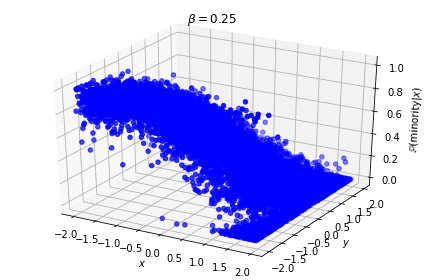

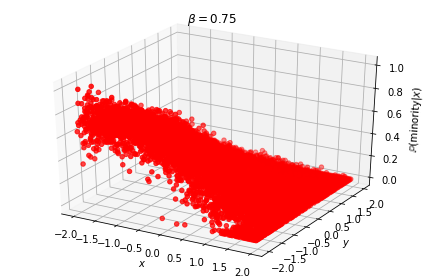

In [27]:
Beta_opt = [0.25,0.75]
posterior_bias2D(x2D_ma,x2D_mi, Beta_opt) #, range_minx=-4, range_maxx=4, range_miny=-4, range_maxy=4)

As $\beta$ decreases the posterior probability, $\mathbb{P}(\mathrm{minority}|x)$, decreases. In other words, removing samples with undersampling moves the classification boundary so that more samples are classified as the minority. The stronger
the undersampling, the larger the shift.

## 4. Impact on Classification

To evaluate the perfomance of this technique, we consider multiple values for $\beta$, and KNN and Naive Bayes models for classification. 

#### Generate Training Dataset

In [28]:
N=1e6
x2D_ma = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N))
x2D_mi = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N))


#### KNN Classification without undersampling

In [29]:
y_training = np.r_[[1]*len(x2D_ma), [-1]*len(x2D_mi)]
x_training = np.r_[x2D_ma,x2D_mi]
KKNClassifier = KNeighborsClassifier(n_neighbors=3).fit(x_training,y_training)
NBClassifier = GaussianNB().fit(x_training,y_training)

#### Prediction and Classification Evaluation

In [30]:
N_test=1e3
x2D_ma_test = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N_test))
x2D_mi_test = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N_test))

x_test = np.r_[x2D_ma_test,x2D_mi_test]
y_test = np.r_[[1]*len(x2D_ma_test), [-1]*len(x2D_mi_test)]

y_pred = KKNClassifier.predict(x_test)
y_pred_bayes_base = NBClassifier.predict(x_test)
f1_base_knn = f1_score(y_test, y_pred, average='weighted')
f1_base_bayes = f1_score(y_test, y_pred_bayes_base, average='weighted')
print(f1_base_knn)

0.8230173835807639


#### Prediction F1-scores using different values for $\beta$

In [31]:
betas = [i for i in list(np.linspace(0.1,0.9,11))]
f1scores_knn = []
f1scores_bayes = []
homog_it = 10

for Beta in tqdm(betas):
    aux_f1_k = np.zeros([1,homog_it])
    aux_f1_b = np.zeros([1,homog_it])
    
    for i in range(homog_it): # Homogenize results
        # Update x2D_ma
        x2D_ma_undersampled = x2D_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N)), :]
        x_training = np.r_[x2D_ma_undersampled,x2D_mi]
        y_training = np.r_[[1]*len(x2D_ma_undersampled), [-1]*len(x2D_mi)]

        # Create classifier
        KKNClassifier = KNeighborsClassifier(n_neighbors=3).fit(x_training,y_training)
        NBClassifier = GaussianNB().fit(x_training,y_training)
        
        y_pred_knn = KKNClassifier.predict(x_test)
        y_pred_bayes = NBClassifier.predict(x_test)
        
        aux_f1_k[0,i] = f1_score(y_test, y_pred_knn, average='weighted')
        aux_f1_b[0,i] = f1_score(y_test, y_pred_bayes, average='weighted')
        
    f1scores_knn.append(np.mean(aux_f1_k))
    f1scores_bayes.append(np.mean(aux_f1_b))
    

100%|██████████| 11/11 [03:23<00:00, 18.48s/it]


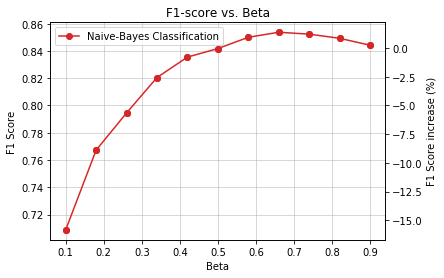

[0.7087008728909101, 0.7672071991238896, 0.794518293876769, 0.8205065142170545, 0.8354846489437936, 0.8417586054721976, 0.8500216694114586, 0.853734168794744, 0.8523419203747074, 0.8492828593301638, 0.8442253262147272]
[0.1, 0.18, 0.26, 0.33999999999999997, 0.42000000000000004, 0.5, 0.58, 0.66, 0.74, 0.82, 0.9]


In [32]:
# Plot results
plt.close()
fig = plt.figure()

ax1 = plt.subplot(111)
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)
#plt.plot(betas,f1scores_knn,'-o',color='tab:blue',label='KKN Classification')
plt.plot(betas,f1scores_bayes,'-o',color='tab:red',label='Naive-Bayes Classification')
ax1.set(title='F1-score vs. Beta', xlabel = 'Beta', ylabel = 'F1 Score')
plt.legend(loc='lower right')
plt.legend()

ax2 = ax1.twinx()
#plt.plot(betas,(f1scores_knn-f1_base_knn)/f1_base_knn*100,'o',color='tab:blue')
plt.plot(betas,(f1scores_bayes-f1_base_bayes)/f1_base_bayes*100,'o',color='tab:red')
ax2.set_ylabel('F1 Score increase (%)')
plt.show()
print(f1scores_bayes)
print(betas)

We observe that extremes values for $\beta$ do not provide the highest F1-scores. We know that the optimum $\beta$ should be within 0 and 1, and that it will depend upon the training dataset. We homogenize the results by calculating the average F1-score for different training sets. We find an optimum at $\beta=0.82$.

#### Comparing ROC curves.
We will compare the ROC curves including the undersampling technique.

In [35]:
# Get Optimum Beta results
Beta = betas[-4]
x2D_ma_undersampled = x2D_ma[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N)), :]
x_training = np.r_[x2D_ma_undersampled,x2D_mi]
y_training = np.r_[[1]*len(x2D_ma_undersampled), [-1]*len(x2D_mi)]
NBClassifier = GaussianNB().fit(x_training,y_training)
y_pred_bayes_undersampled = NBClassifier.predict(x_test)

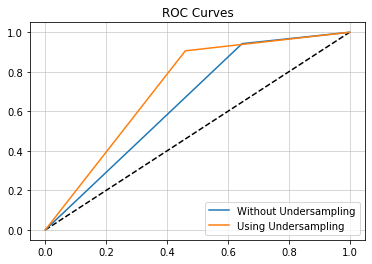

In [36]:
# Plot ROC curves
a, b, _ = roc_curve(y_test, y_pred_bayes_base)
c, d, _ = roc_curve(y_test, y_pred_bayes_undersampled)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(a, b, label = 'Without Undersampling')
plt.plot(c, d, label='Using Undersampling')
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)
plt.title('ROC Curves')
plt.legend()
plt.show()